# E-commerce users activity analysis

**Target:** Identify loyal users to provide discounts on a specific product

**Analysis answers:**
- Which users can be provided with a loyalty card?
- Are there any loyal users at all?

In [83]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('../../../data/01_module/03_part/lesson_3_data_1_.csv', encoding='windows-1251')

In [5]:
df.head()

,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


### Getting the main columns

In [6]:
user_df = df[['tc', 'art_sp']]
user_df

,tc,art_sp
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2
...,...,...
48124,45518841,FIDEOS 0 500 G Brand_4
48125,110824211,PLUMAS 3 500 G Brand_4
48126,1408670389,MACARRONES 500 G Store_Brand
48127,1408670389,SPAGHETTI 500 G Store_Brand


## Data preprocessing

In [12]:
user_df = user_df.rename(columns={
    'tc': 'user_id',
    'art_sp': 'brand_info'
})

In [14]:
user_df.head()

,user_id,brand_info
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


In [18]:
def split_brand(brand_name_date):
    return brand_name_date.split(' ')[-1]

In [23]:
# An alternative way
# user_df['brand_name'] = user_df.brand_info.apply(lambda brand_info: brand_info.split(' ')[-1])

In [25]:
user_df['brand_name'] = user_df.brand_info.apply(split_brand)

In [26]:
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


## Aggregate users by purchases

In [43]:
users_purchases = (
    user_df.groupby('user_id', as_index=False)
        .agg({'brand_name': 'count'})
        .rename(columns={'brand_name': 'purchases'})
)

In [44]:
users_purchases.head()

,user_id,purchases
0,-1236394515,1
1,1031,6
2,4241,5
3,17311,2
4,17312,2


In [45]:
users_purchases.shape

(11764, 2)

In [46]:
users_purchases.purchases.describe()

count    11764.000000
mean         4.091210
std          4.573143
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         60.000000
Name: purchases, dtype: float64

*25% users made more than 5 purchases*

In [50]:
users_purchases = users_purchases.query('purchases >= 5')

In [51]:
users_purchases.head()

,user_id,purchases
1,1031,6
2,4241,5
11,25971,7
14,40911,27
16,45181,5


## Group users by unique brands

In [67]:
users_unique_brands = (
    user_df.groupby('user_id', as_index=False)
        .agg({'brand_name': pd.Series.nunique})
        .rename(columns={'brand_name': 'unique_brands'})
)

## Group users by brand and select lovely brand

In [63]:
lovely_brand_purchases_df = (
    user_df.groupby(['user_id', 'brand_name'], as_index=False)
        .agg({'brand_info': 'count'})
        .sort_values(by=['user_id', 'brand_info'], ascending=[False, False])
        .groupby('user_id')
        .head(1)
        .rename(columns={
            'brand_name': 'lovely_brand',
            'brand_info': 'lovely_brand_purchases'
        })
)

## Merge all data

In [72]:
loyalty_df = (
    users_purchases
        .merge(users_unique_brands, on='user_id')
        .merge(lovely_brand_purchases_df, on='user_id')
)

In [73]:
loyalty_df.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
0,1031,6,2,Store_Brand,5
1,4241,5,2,Brand_4,3
2,25971,7,2,Store_Brand,5
3,40911,27,5,Brand_4,19
4,45181,5,4,Store_Brand,2


In [76]:
loyal_users = loyalty_df[loyalty_df['unique_brands'] == 1]

In [85]:
loyalty_df['loyalty_score'] = loyalty_df.lovely_brand_purchases / loyalty_df.purchases

In [86]:
loyalty_df.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
1,4241,5,2,Brand_4,3,0.600000
2,25971,7,2,Store_Brand,5,0.714286
3,40911,27,5,Brand_4,19,0.703704
4,45181,5,4,Store_Brand,2,0.400000


## Visualization

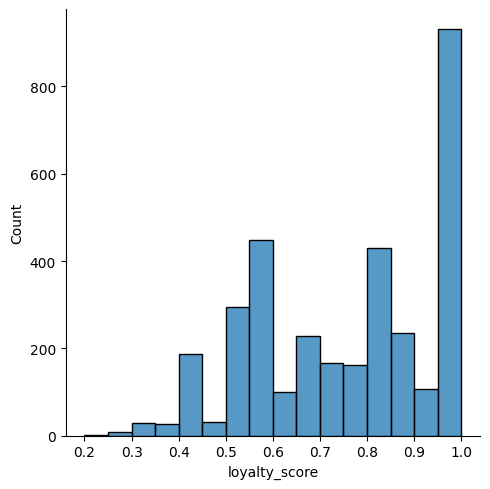

In [92]:
ax = sns.displot(loyalty_df.loyalty_score)

## Group by lovely brands

In [102]:
brands_loyalty = (
    loyalty_df.groupby('lovely_brand', as_index=False)
        .agg({'loyalty_score': 'median', 'user_id': 'count'})
)

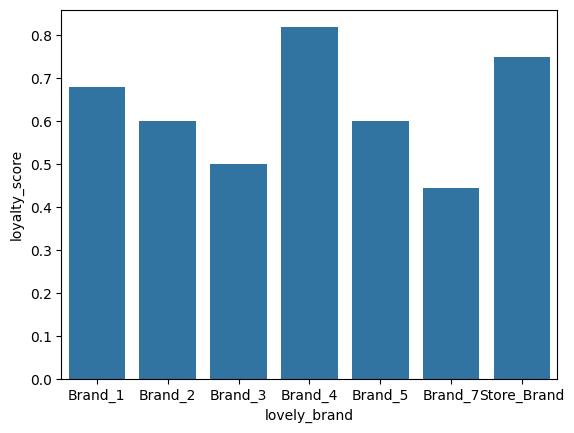

In [105]:
ax = sns.barplot(x='lovely_brand', y='loyalty_score', data=brands_loyalty)